2.6174676669763373


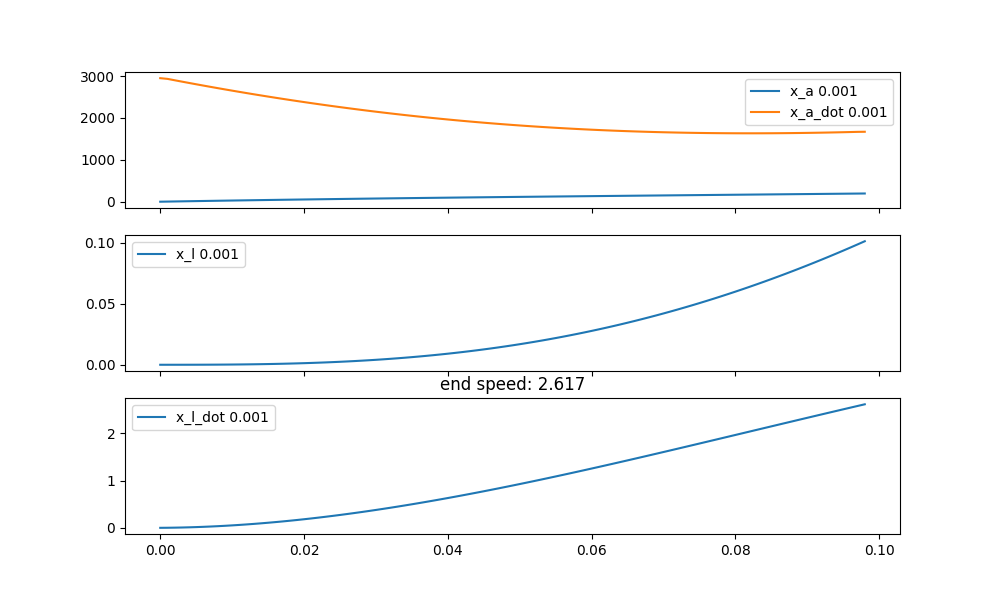

In [207]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget


T1 = 0.00025 #0.035 m / 140 rad from TSA test
T2 = 5 #guess for leg movement/string contract
m_a = 1/2 * 0.020 * 0.010**2 #cylinder MOI 20g 10mm radius
m_l = 0.5 #mass to push off ground
k = 3000 # no idea honestly

tau_max = 0.05 #N*m stall torque
omega_max = 3000 #about 10,000rpm free speed

c1 = -k * T1**2 * omega_max / tau_max
c2 = k * T1 * omega_max / (tau_max * T2)
c3 = k * T1 / (T2 * m_l)
c4 = -k / (T2**2 * m_l)

# Xdot = A*X where X = [x_a, x_l, x_l_dot]
A = np.array([
    [c1, c2, 0],
    [0, 0, 1],
    [c3, c4, 0],
])
b = [omega_max, 0, 0]


def f(X):
    X = np.array(X).reshape(3)
    return A@X + b

def RK4(f, X, dt):
    # Runge-Kutta 4 integration
    k1 = f(X)
    k2 = f(X + (dt/2)*k1)
    k3 = f(X + (dt/2)*k2)
    k4 = f(X + dt*k3)
    return X + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

X = np.array([0, 0, 0])
log = []

dt = 0.001
times = []
for ti in np.arange(0, 0.5, dt):
    X = RK4(f, X, dt)
    times.append(ti)
    log.append(X)

    if(X[1] > 0.1 or X[2] < 0):
        break

log = np.array(log)
endv = log[:,2][-1]
print(endv)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,6))
axs[0].plot(times, log[:,0], label=f'x_a {dt}')

axs[0].plot(times, np.gradient(log[:,0])/dt, label=f'x_a_dot {dt}')

axs[1].plot(times, log[:,1], label=f'x_l {dt}')

axs[2].plot(times, log[:,2], label=f'x_l_dot {dt}')
axs[2].set_title(f'end speed: {np.round(endv, 3)}')

for ax in axs:
    ax.legend()
plt.show()

In [193]:
from numpy import sqrt, exp

x_ls = []

for t in times:

    x0 = T1*T2*omega_max
    x1 = tau_max**2
    x2 = 4*x1
    x3 = k*m_l
    x4 = T1**4*T2**2*omega_max**2
    x5 = -x2 + x3*x4

    x3 = np.complex64(x3)

    x6 = sqrt(x3*x5)
    x7 = T1**2*omega_max
    x8 = T2*x7
    x9 = x6*x8
    x10 = x3*x8
    x11 = x10 + x6
    x12 = x2*x3
    x13 = k**2*m_l**2
    x14 = sqrt(-x12 + x13*x4)
    x15 = x10 - x14
    x16 = 2*T2*m_l*tau_max
    x17 = x16/x15
    x19 = 1/(T2*m_l)
    x20 = (1/2)*t/tau_max
    x21 = x19*x20
    x22 = 2*x1
    x23 = x0*x22
    x24 = x23*exp(-x15*x21)/(x10 - x6)
    x25 = k*x7
    x26 = x19*x6
    x27 = x10 + x14
    x28 = x16/x27
    x29 = x3/x6
    x30 = x23*exp(-x21*x27)/x11
    x31 = tau_max**4
    x32 = T1**6*T2**3*omega_max**3
    x33 = 2*x31
    x34 = T1**8*T2**4*omega_max**4*x13
    x35 = x12*x4
    x_lcode = t*x0 + x11*x24*x17/(x5 + x9) - x24*x29*(x17*exp(x20*(x25 - x26))) + x29*x30*(x28*exp(x20*(x25 + x26))) - x3*x30*(-x22*x9 + x3*x32*x6 + x33 + x34 - x35)*x28/(T1**10*T2**5*k**3*m_l**3*omega_max**5 - 6*x1*x13*x32 + 8*x10*x31 + x33*x6 + x34*x6 - x35*x6)
    
    x_ls.append(np.real(x_lcode))

x_ls = np.array(x_ls)

axs[1].plot(times, x_ls, label=f'x_lcode')
axs[1].legend()

In [152]:
X = np.array([0, 0, 0])
log = []

dt = 0.001
times = []
for ti in np.arange(0, 0.5, dt):
    X = RK4(f, X, dt)
    times.append(ti)
    log.append(X)

    if(X[1] > 0.1 or X[2] < 0):
        break

log = np.array(log)

axs[0].plot(times, log[:,0], label=f'x_a {dt}')

axs[0].plot(times, np.gradient(log[:,0])/dt, label=f'x_a_dot {dt}')

axs[1].plot(times, log[:,1], label=f'x_l {dt}')

axs[2].plot(times, log[:,2], label=f'x_l_dot {dt}')

for ax in axs:
    ax.legend()

In [208]:
def get_state(t, x_a0=0, x_l0=0, v_l0=0):
    x0 = 1/tau_max
    x1 = k*m_l
    x2 = T2**2
    x3 = omega_max**2
    x4 = x2*x3
    x5 = T1**4*x1*x4 - 4*tau_max**2
    x6 = sqrt(complex(x1)*x5)
    x7 = 2*x6
    x8 = t*tau_max
    x9 = tau_max*x_a0
    x10 = T2*v_l0
    x11 = T1*omega_max
    x12 = m_l*x11
    x13 = T1**2
    x14 = -m_l*x13*x4 + x10*x12 + x9
    x15 = omega_max*x1*x13
    x16 = T2*x15
    x17 = 1/T2
    x18 = (1/2)*t*x0*x17/m_l
    x19 = exp(-x18*(x16 + x6))
    x20 = x10*x6
    x21 = x11*x2
    x22 = x21*x6
    x23 = 2*k
    x24 = T1*T2
    x25 = T1**3*T2**3*x1*x3 + tau_max*x23*x_l0 - v_l0*x15*x2 - x23*x24*x9
    x26 = x20 - x22 + x25
    x27 = x19*x26
    x28 = exp(x18*(-x16 + x6))
    x29 = -x20 + x22 + x25
    x30 = (1/2)/x6
    x31 = k*x5
    x32 = x28*x29
    x_a_code = x0*x30*(omega_max*x7*x8 + x12*(-x27 + x28*x29) + x14*x7)
    x_l_code = x0*((1/4)*T2*omega_max*x13*x6*(-x19*x26 + x32) + T2*x11*x31*x8 + x14*x24*x31 + (1/4)*x5*(x27 + x32))/(k*x5)
    v_l_code = x17*x30*(x21*x7 + x27 - x28*x29)

    return np.real([x_a_code, x_l_code, v_l_code])

times = []
log = []
for ti in np.arange(0, 0.5, dt):
    X = get_state(ti)
    times.append(ti)
    log.append(X)

    if(X[1] > 0.1 or X[2] < 0):
        break

log = np.array(log)

print(log)

# fig, axs = plt.subplots(3, 1, sharex=0)
axs[0].plot(times, log[:,0], label='x_a ana')
# axs[0].plot(times, np.gradient(log[:,0])/dt, label=f'x_a_dot ana')

axs[1].plot(times, log[:,1], label='x_l ana')
axs[2].plot(times, log[:,2], label='v_l ana')

for ax in axs:
    ax.legend()

[[1.96899073e-14 2.13136179e-17 0.00000000e+00]
 [2.98318844e+00 1.49577279e-07 4.48308276e-04]
 [5.93300877e+00 1.19322309e-06 1.78643289e-03]
 [8.84984624e+00 4.01562500e-06 4.00410016e-03]
 [1.17340897e+01 9.49114911e-06 7.09094145e-03]
 [1.45861314e+01 1.84837468e-05 1.10364966e-02]
 [1.74063668e+01 3.18468653e-05 1.58302178e-02]
 [2.01951948e+01 5.04233611e-05 2.14614724e-02]
 [2.29530170e+01 7.50454177e-05 2.79195472e-02]
 [2.56802381e+01 1.06534466e-04 3.51936513e-02]
 [2.83772655e+01 1.45701109e-04 4.32729199e-02]
 [3.10445093e+01 1.93345050e-04 5.21464175e-02]
 [3.36823822e+01 2.50255020e-04 6.18031414e-02]
 [3.62912991e+01 3.17208720e-04 7.22320252e-02]
 [3.88716772e+01 3.94972749e-04 8.34219419e-02]
 [4.14239360e+01 4.84302554e-04 9.53617074e-02]
 [4.39484969e+01 5.85942368e-04 1.08040084e-01]
 [4.64457832e+01 7.00625162e-04 1.21445782e-01]
 [4.89162200e+01 8.29072595e-04 1.35567467e-01]
 [5.13602340e+01 9.71994966e-04 1.50393759e-01]
 [5.37782536e+01 1.13009118e-03 1.659132